<a href="https://colab.research.google.com/github/abdullahalmusabbir/Review-Paper-Code/blob/main/16_AI_Powered_Diagnosis_A_Machine_Learning_Approach_to_Early_Detection_of_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

# Sklearn Models
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Deep Learning
import tensorflow as tf
from tensorflow.keras import models, layers

In [20]:
path = kagglehub.dataset_download("uciml/breast-cancer-wisconsin-data")
print("Dataset Path:", path)

df = pd.read_csv(path + "/data.csv")   # main file inside folder is "data.csv"
print(df.head())

# Drop unnecessary columns if present
df = df.drop(columns=["Unnamed: 32", "id"], errors="ignore")

X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

print("Features Shape:", X.shape)
print("Target Shape:", y.shape)

Dataset Path: /kaggle/input/breast-cancer-wisconsin-data
         id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   ..

In [21]:
le = LabelEncoder()
y = le.fit_transform(y)   # M=1, B=0

print("Encoded target sample:", y[:10])

Encoded target sample: [1 1 1 1 1 1 1 1 1 1]


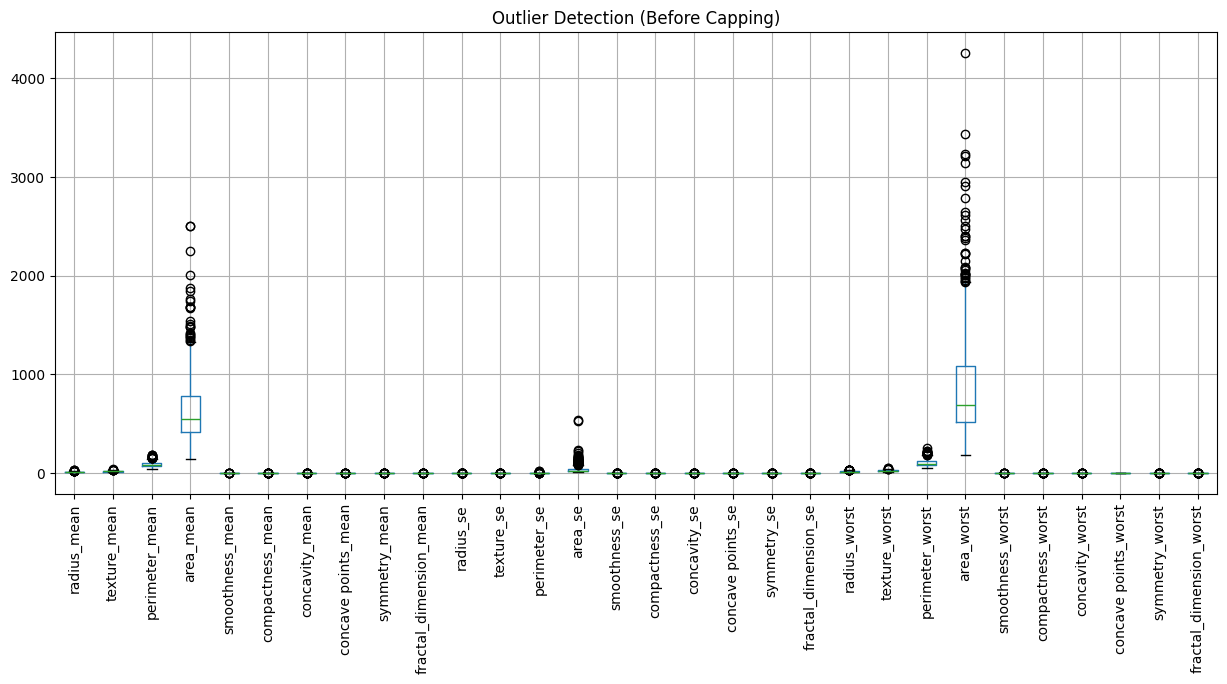

In [22]:
plt.figure(figsize=(15,6))
X.boxplot(rot=90)
plt.title("Outlier Detection (Before Capping)")
plt.show()

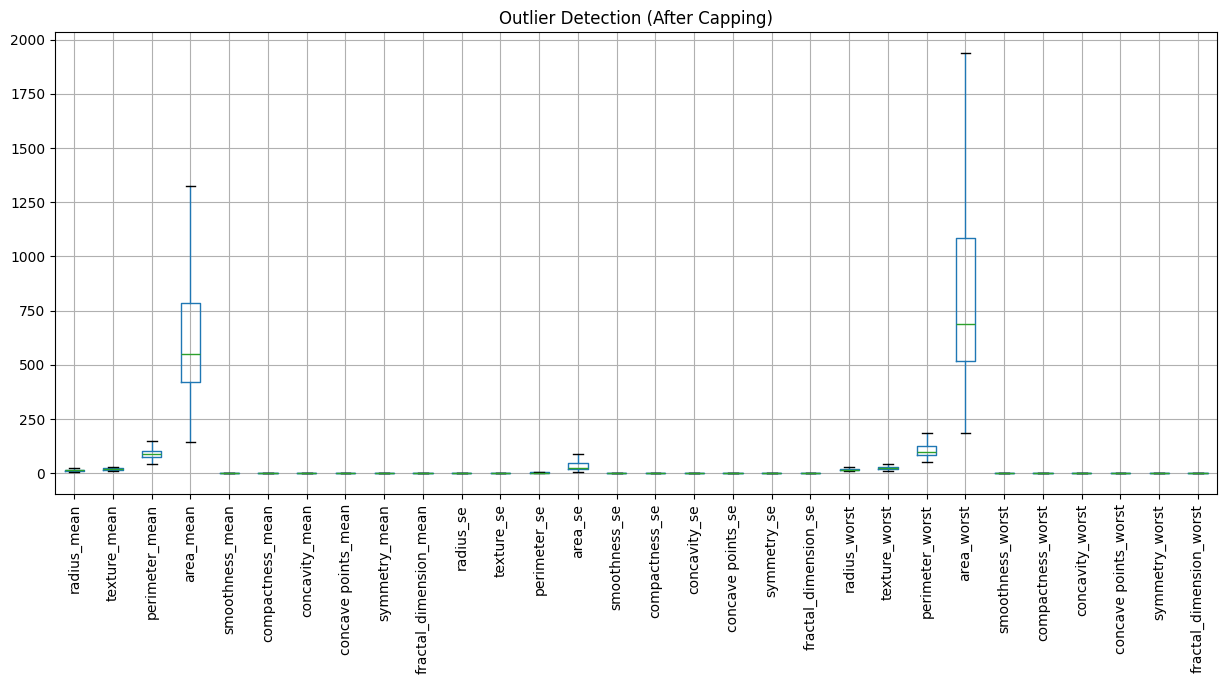

In [23]:
def cap_outliers(df):
    capped_df = df.copy()
    for col in df.select_dtypes(include=np.number).columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        capped_df[col] = np.where(df[col] < lower, lower,
                           np.where(df[col] > upper, upper, df[col]))
    return capped_df

X_capped = cap_outliers(X)

# Outlier after capping
plt.figure(figsize=(15,6))
X_capped.boxplot(rot=90)
plt.title("Outlier Detection (After Capping)")
plt.show()

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_capped)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print("Train Shape:", X_train.shape, "Test Shape:", X_test.shape)

Train Shape: (455, 10) Test Shape: (114, 10)


In [27]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print("\nRandom Forest Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.956140350877193
Confusion Matrix:
 [[72  0]
 [ 5 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [28]:
ann_model = MLPClassifier(hidden_layer_sizes=(64,32), max_iter=1000, random_state=42)
ann_model.fit(X_train, y_train)
y_pred_ann = ann_model.predict(X_test)

print("\nANN (MLP) Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_ann))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ann))
print("Classification Report:\n", classification_report(y_test, y_pred_ann))


ANN (MLP) Results:
Accuracy: 0.9736842105263158
Confusion Matrix:
 [[72  0]
 [ 3 39]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        72
           1       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



In [29]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

cnn_model = models.Sequential([
    layers.Conv1D(32, 3, activation="relu", input_shape=(X_train.shape[1],1)),
    layers.MaxPooling1D(2),
    layers.Conv1D(64, 3, activation="relu"),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

cnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

history = cnn_model.fit(X_train_cnn, y_train, epochs=20, batch_size=32,
                        validation_split=0.2, verbose=0)

cnn_eval = cnn_model.evaluate(X_test_cnn, y_test, verbose=0)
y_pred_cnn = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")

print("\nCNN Results:")
print("Accuracy:", cnn_eval[1])
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_cnn))
print("Classification Report:\n", classification_report(y_test, y_pred_cnn))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

CNN Results:
Accuracy: 0.9736841917037964
Confusion Matrix:
 [[69  3]
 [ 0 42]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98        72
           1       0.93      1.00      0.97        42

    accuracy                           0.97       114
   macro avg       0.97      0.98      0.97       114
weighted avg       0.98      0.97      0.97       114



# **Second part**

In [43]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import to_categorical

In [44]:
path = "/kaggle/input/mias-mammography"
img_dir = os.path.join(path, "all-mias")
metadata_path = os.path.join(path, "Info.txt")

# Read Info.txt
labels = pd.read_csv(metadata_path, sep=' ', header=None,
                     names=['study_id', 'category', 'attributes', 'severity', 'x_coord', 'y_coord', 'radius'])

print("Metadata preview:\n", labels.head())

Metadata preview:
        study_id category attributes severity x_coord y_coord  radius
REFNUM       BG    CLASS   SEVERITY        X       Y  RADIUS     NaN
mdb001        G     CIRC          B      535     425     197     NaN
mdb002        G     CIRC          B      522     280      69     NaN
mdb003        D     NORM        NaN      NaN     NaN     NaN     NaN
mdb004        D     NORM        NaN      NaN     NaN     NaN     NaN


In [33]:
# Verify the contents of the downloaded directory
!ls "/root/.cache/kagglehub/datasets/kmader/mias-mammography/versions/1/"
!ls "/root/.cache/kagglehub/datasets/kmader/mias-mammography/versions/1/all-mias"

ls: cannot access '/root/.cache/kagglehub/datasets/kmader/mias-mammography/versions/1/': No such file or directory
ls: cannot access '/root/.cache/kagglehub/datasets/kmader/mias-mammography/versions/1/all-mias': No such file or directory


In [34]:
import kagglehub
path = kagglehub.dataset_download("kmader/mias-mammography")
print("Actual Dataset Path:", path)

Actual Dataset Path: /kaggle/input/mias-mammography


In [37]:
!ls "/kaggle/input/mias-mammography/"

all-mias  all_mias_scans.h5  all-mias.tar.gz  Info.txt


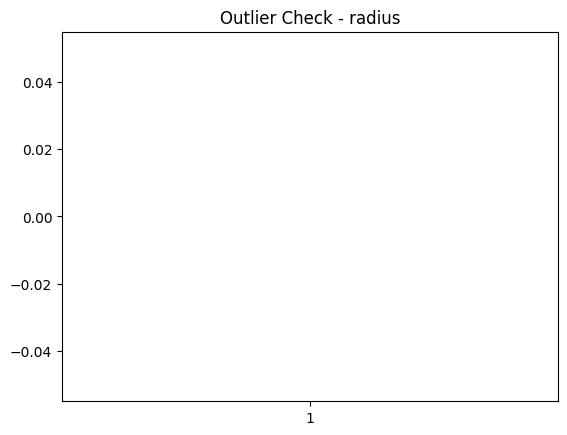

In [45]:
import matplotlib.pyplot as plt
plt.boxplot(labels['radius'].dropna())
plt.title("Outlier Check - radius")
plt.show()

# Cap outliers (IQR method)
Q1 = labels['radius'].quantile(0.25)
Q3 = labels['radius'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
labels['radius_capped'] = np.where(labels['radius'] > upper_bound, upper_bound,
                          np.where(labels['radius'] < lower_bound, lower_bound, labels['radius']))


In [46]:
le_category = LabelEncoder()
labels['category_enc'] = le_category.fit_transform(labels['category'])
labels['severity_enc'] = LabelEncoder().fit_transform(labels['severity'])

In [79]:
import tarfile
import os
import cv2

tar_path = os.path.join(path, "all-mias.tar.gz")
extract_dir = "/tmp/" # Extract directly to /tmp/
example_img_check_path = os.path.join(extract_dir, "mdb001.pgm")
if not os.path.exists(example_img_check_path):
    print(f"Extracting {tar_path} to {extract_dir}...")
    try:
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_dir)
        print("Extraction complete.")
    except tarfile.ReadError as e:
        print(f"Error extracting tarball: {e}")
        raise

img_dir = extract_dir

IMG_SIZE = 64

data = []
y_labels = []

labels_data_rows = labels[labels['study_id'] != 'REFNUM'].copy().reset_index(drop=True)
print(f"Number of rows in labels_data_rows after filtering header and resetting index: {len(labels_data_rows)}")

if len(labels_data_rows) == 0:
    print("No valid data rows found in labels after filtering header.")

else:
    print("\nChecking existence of first 5 image files:")
    for i, row in labels_data_rows.head().iterrows():
        img_filename = row["study_id"] + ".pgm"
        img_path = os.path.join(img_dir, img_filename)
        file_exists = os.path.exists(img_path)
        print(f"Checking path: {img_path}, Exists: {file_exists}")


    for idx, row in labels_data_rows.iterrows():
        img_filename = row["study_id"] + ".pgm"
        img_path = os.path.join(img_dir, img_filename)

        if os.path.exists(img_path):
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            data.append(img)
            y_labels.append(row["category"])


X_images = np.array(data)

if len(y_labels) == 0:
    print("\nNo images were loaded. Cannot proceed with splitting and scaling.")
else:
    le = LabelEncoder()
    y_labels_encoded = le.fit_transform(y_labels)

    print("Image data shape:", X_images.shape)
    print("Labels shape:", y_labels_encoded.shape)

    X_train, X_test, y_train, y_test = train_test_split(X_images, y_labels_encoded, test_size=0.2, random_state=42, stratify=y_labels_encoded)

    X_train_flat = X_train.reshape(len(X_train), -1)
    X_test_flat = X_test.reshape(len(X_test), -1)

    scaler = StandardScaler()
    X_train_flat = scaler.fit_transform(X_train_flat)
    X_test_flat = scaler.transform(X_test_flat)

    print("\nData splitting and scaling complete.")

Number of rows in labels_data_rows after filtering header and resetting index: 331

Checking existence of first 5 image files:
Checking path: /tmp/BG.pgm, Exists: False
Checking path: /tmp/G.pgm, Exists: False
Checking path: /tmp/G.pgm, Exists: False
Checking path: /tmp/D.pgm, Exists: False
Checking path: /tmp/D.pgm, Exists: False

No images were loaded. Cannot proceed with splitting and scaling.


In [56]:
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Results:")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))

In [63]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
evaluate_model(y_test, rf.predict(X_test), "Random Forest")


Random Forest Results:
Accuracy: 0.956140350877193
Confusion Matrix:
 [[72  0]
 [ 5 37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      1.00      0.97        72
           1       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



In [64]:
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
evaluate_model(y_test, svm.predict(X_test), "SVM")


SVM Results:
Accuracy: 0.9473684210526315
Confusion Matrix:
 [[70  2]
 [ 4 38]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.97      0.96        72
           1       0.95      0.90      0.93        42

    accuracy                           0.95       114
   macro avg       0.95      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In [68]:
num_classes = len(np.unique(y_train))

ann = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax') # Use num_classes here
])

# Use sparse_categorical_crossentropy for integer labels
ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training ANN model...")
ann.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.1)
print("Training complete.")


print("\nEvaluating ANN model...")
y_pred_ann_probs = ann.predict(X_test)
y_pred_ann = np.argmax(y_pred_ann_probs, axis=1) # Get the class with the highest probability

evaluate_model(y_test, y_pred_ann, "ANN")

Training ANN model...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4573 - loss: 0.7017 - val_accuracy: 0.3696 - val_loss: 0.6801
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6757 - loss: 0.6048 - val_accuracy: 0.9348 - val_loss: 0.5319
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9221 - loss: 0.4829 - val_accuracy: 0.9348 - val_loss: 0.4039
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8988 - loss: 0.3621 - val_accuracy: 0.9348 - val_loss: 0.2603
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9263 - loss: 0.2453 - val_accuracy: 0.9348 - val_loss: 0.2119
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9231 - loss: 0.1859 - val_accuracy: 0.8696 - val_loss: 0.2904
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9300 - loss: 0.1671 - val_accuracy: 0.9348 - val_loss: 0.2271
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9317 - loss: 0.1605 - val_accur

In [85]:
path = "/kaggle/input/mias-mammography"
img_dir = os.path.join(path, "all-mias")
metadata_path = os.path.join(path, "Info.txt")

labels = pd.read_csv(metadata_path, delim_whitespace=True, header=None)
labels.columns = ["study_id", "bg", "abnorm", "severity", "x", "y", "radius"]

print("Labels shape:", labels.shape)
print(labels.head())

labels["label"] = labels["abnorm"].apply(lambda x: 0 if x == "NORM" else 1)

X, y = [], []

for _, row in labels.iterrows():
    study_id = row["study_id"]
    label = row["label"]
    img_path = os.path.join(img_dir, f"{study_id}.pgm")
    if os.path.exists(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img_resized = cv2.resize(img, (64, 64))
            X.append(img_resized)
            y.append(label)

X = np.array(X).reshape(-1, 64, 64, 1).astype("float32") / 255.0
y = np.array(y)

print("✅ Final dataset:")
print("X shape:", X.shape)
print("y samples:", len(y))
print("Classes:", np.unique(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/tmp/ipython-input-1283925391.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels = pd.read_csv(metadata_path, delim_whitespace=True, header=None)


Labels shape: (331, 7)
  study_id  bg abnorm  severity    x    y  radius
0   REFNUM  BG  CLASS  SEVERITY    X    Y  RADIUS
1   mdb001   G   CIRC         B  535  425     197
2   mdb002   G   CIRC         B  522  280      69
3   mdb003   D   NORM       NaN  NaN  NaN     NaN
4   mdb004   D   NORM       NaN  NaN  NaN     NaN
✅ Final dataset:
X shape: (330, 64, 64, 1)
y samples: 330
Classes: [0 1]


In [86]:
IMG_SIZE = 64

cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = cnn.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 390ms/step - accuracy: 0.4907 - loss: 0.7371 - val_accuracy: 0.6296 - val_loss: 0.6673
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.6102 - loss: 0.6686 - val_accuracy: 0.6296 - val_loss: 0.6604
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 0.5832 - loss: 0.6660 - val_accuracy: 0.6296 - val_loss: 0.6657
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 0.6711 - loss: 0.6208 - val_accuracy: 0.6296 - val_loss: 0.6702
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 0.6494 - loss: 0.6235 - val_accuracy: 0.5926 - val_loss: 0.6745
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.6885 - loss: 0.5987 - val_accuracy: 0.5926 - val_loss: 0.6853
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.6601 - loss: 0.5957 - val_accuracy: 0.5556 - val_loss: 0.7014
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.6686 - loss: 0.5934 - val_accuracy: 0.5926 - val_loss:

In [87]:
def evaluate_model_cnn(model, X_test, y_test, model_name="CNN"):
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int).reshape(-1)

    print(f"\n{model_name} Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

evaluate_model_cnn(cnn, X_test, y_test, "CNN Model")

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step

CNN Model Results:
Accuracy: 0.6060606060606061
Confusion Matrix:
 [[35 10]
 [16  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.78      0.73        45
           1       0.33      0.24      0.28        21

    accuracy                           0.61        66
   macro avg       0.51      0.51      0.50        66
weighted avg       0.57      0.61      0.59        66

